In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{6}"

In [3]:
import torch
import torch.nn as nn

import numpy as np
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim

from torchvision import transforms
import matplotlib.pyplot as plt

/home/dg321/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

In [4]:
xysize = 384
xysize_latent = 96
timesteps = 399

### Load flow data

In [5]:
Latent_data_Velocity = np.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data_9_9/Latent_data_Velocity_{}_{}_326464.npy'.format(xysize, xysize))
Latent_data_Velocity = Latent_data_Velocity.reshape(timesteps, 32, xysize_latent, xysize_latent)
print(Latent_data_Velocity.shape)

(399, 32, 96, 96)


In [6]:
# training set
Latent_data_Velocity_training = Latent_data_Velocity[:timesteps - 50,:,:,:]

In [7]:
# test set
Latent_data_Velocity_test = Latent_data_Velocity[timesteps - 50:,:,:,:]

In [8]:
# # save training and test sets
# np.save('/home/dg321/gitTest/PRI/irp/Flow_Data/Latent_data_VelocityXs_training.npy', Latent_data_Velocity_training)
# np.save('/home/dg321/gitTest/PRI/irp/Flow_Data/Latent_data_VelocityXs_test.npy', Latent_data_Velocity_test)

### Load building data

In [9]:
Latent_data_Building = np.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data_9_9/Latent_data_Building_{}_{}_326464.npy'.format(xysize, xysize))
Latent_data_Building = Latent_data_Building.reshape(1, 16, xysize_latent, xysize_latent)
print(Latent_data_Building.shape)

(1, 16, 96, 96)


#### Reconstruct building data

(1, 16, 96, 96)
torch.Size([16, 96, 96])
(1, 384, 384)


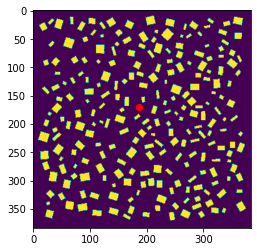

In [10]:
# Load the saved cae for building

## for building
class Autoencoder_building(nn.Module):
    def __init__(self):
        super(Autoencoder_building, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU()
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2, padding=0),   # Change kernel_size and stride to 2
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoencoder_building = Autoencoder_building()  # Assuming you have the ConvAutoencoder class defined
autoencoder_building.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/MainCodes/models/autoencoder_Flow_Building_256_256_2000epochs.pth'))

autoencoder_building.eval()  # Set the autoencoder to evaluation mode

print(Latent_data_Building.shape)
input_data = torch.from_numpy(Latent_data_Building[0]).float()
print(input_data.shape)
res = autoencoder_building.decoder(input_data)
output_data_building = res.detach().numpy()
print(output_data_building.shape)

plt.figure()
plt.imshow(output_data_building[0])
# Plot the dot on the image
plt.scatter(186, 170, color='red', marker='o')
output_data = output_data_building

In [11]:
# Set a seed for reproducibility
np.random.seed(42)

# Get the indices of 0 values
sensors_indices = np.argwhere(output_data <= 0.00001)

# Number of points to randomly select
num_points_to_select = 10

# Randomly select indices
selected_indices = sensors_indices[np.random.choice(len(sensors_indices), size=num_points_to_select, replace=False)]

# Print the selected indices
print("Selected Indices:")
print(selected_indices)

Selected Indices:
[[  0 185 318]
 [  0 338  50]
 [  0 254 158]
 [  0 281 159]
 [  0 283  24]
 [  0 378 304]
 [  0 289 291]
 [  0 286 275]
 [  0  65 170]
 [  0 119  85]]


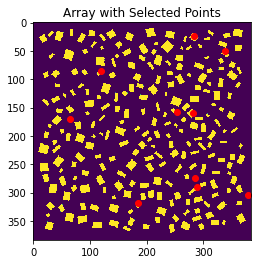

In [12]:
# Visualize the array and selected points
plt.imshow(output_data[0], interpolation='none')

# Plot selected points as red dots
plt.scatter(selected_indices[:, 1], selected_indices[:, 2], color='red', marker='o')

plt.title('Array with Selected Points')
plt.show()


#### Create sensors

In [13]:
sensors_x = selected_indices[:, 1]
sensors_y = selected_indices[:, 2]

### Combine Velocity and Building

In [14]:
n_sampels = 200
t_gaps_sampels = 1  ## 10 used to train the model
dt = 5
ntimes = 3

batch_size = 16  # Choose your desired batch size

samples_training = []
samples_training_X = []
samples_training_Y = []

for i in range(1, n_sampels+1):
    ii = 1 + i*t_gaps_sampels
    # s = np.concatenate([Latent_data_VelocityXs_training[ss] for ss in range(ii,ii + dt*ntimes, dt )], axis = 0)
    s = np.stack([Latent_data_Velocity_training[ss] for ss in range(ii,ii + dt*ntimes, dt )])
    s_building = Latent_data_Building
    # ss_0 = np.concatenate((s[0].reshape(1, 32, xysize_latent, xysize_latent), s_building), axis=1)   # X
    ss_0 = np.concatenate((s[0].reshape(1, 32, xysize_latent, xysize_latent), s[1].reshape(1, 32, xysize_latent, xysize_latent), s[2].reshape(1, 32, xysize_latent, xysize_latent), s_building), axis=1)   # X

    # ss_1 = s[2].reshape(1, 32, xysize_latent, xysize_latent)   # Y
    ss_1 = ss_0


    ss = (ss_0, ss_1)
    print(ss[0].shape)
    print(ss[1].shape)
    samples_training.append(ss)
    samples_training_X.append(ss_0)
    samples_training_Y.append(ss_1)

(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 9

In [15]:
samples_training_X_stacked = (np.stack(samples_training_X)).reshape(n_sampels, ss_0.shape[1], xysize_latent, xysize_latent)
print(samples_training_X_stacked.shape)

(200, 112, 96, 96)


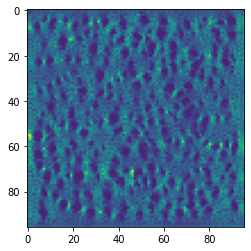

In [16]:
plt.imshow(samples_training_X_stacked[0][0])

In [17]:
samples_training_Y_stacked = (np.stack(samples_training_Y)).reshape(n_sampels, ss_1.shape[1], xysize_latent, xysize_latent)
print(samples_training_Y_stacked.shape)

(200, 112, 96, 96)


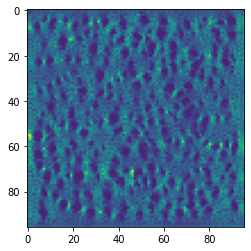

In [18]:
plt.imshow(samples_training_Y_stacked[0][0])

(array([798421., 206687.,  14655.,   3982.,   1611.,   1888.,   1603.,
          1315.,   1194.,    836.]),
 array([ 0.       ,  2.4357257,  4.8714514,  7.3071775,  9.742903 ,
        12.178629 , 14.614355 , 17.050081 , 19.485806 , 21.921532 ,
        24.357258 ], dtype=float32),
 <BarContainer object of 10 artists>)

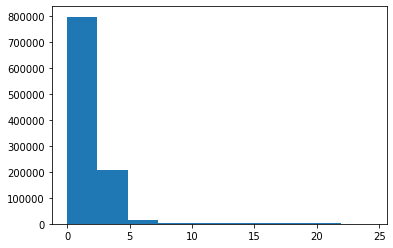

In [19]:
plt.hist(samples_training_X_stacked[0].flatten())

(array([59043., 68729.,  7610.,  3635.,  1603.,  1888.,  1603.,  1315.,
         1194.,   836.]),
 array([ 0.       ,  2.4357257,  4.8714514,  7.3071775,  9.742903 ,
        12.178629 , 14.614355 , 17.050081 , 19.485806 , 21.921532 ,
        24.357258 ], dtype=float32),
 <BarContainer object of 10 artists>)

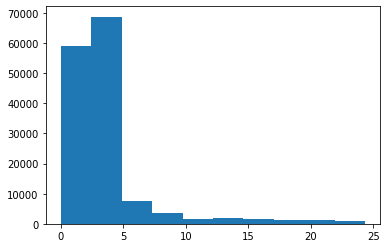

In [20]:
plt.hist(Latent_data_Building.flatten())

## Create data loader

In [21]:
data = samples_training
print(len(data))

200


In [22]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, idx):
        sample = {'input': self.data_x[idx], 'target': self.data_y[idx]}
        return sample

# Create an instance of your custom dataset
my_dataset = MyDataset(samples_training_X_stacked, samples_training_Y_stacked)

# Create a DataLoader for batching and shuffling the data

shuffle = True  # Set to True if you want to shuffle the data during training

data_loader = DataLoader(my_dataset, batch_size=batch_size, shuffle=shuffle)


In [23]:
from torch.utils.data import Dataset, DataLoader, random_split

split_ratio = 0.9

# Calculate the sizes of the training and validation sets
total_size = len(samples_training_X_stacked)
train_size = int(split_ratio * total_size)
val_size = total_size - train_size

# Create an instance of your custom dataset
my_dataset = MyDataset(samples_training_X_stacked, samples_training_Y_stacked)

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(my_dataset, [train_size, val_size])

# Create DataLoader instances for training and validation
batch_size = 16 
shuffle_train = True
shuffle_val = False  # Validation data doesn't need to be shuffled

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_train)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle_val)

## Define the model

### AAE

In [47]:
# Encoder and Decoder (same as before)
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(ss_0.shape[1], 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # Add more convolutional layers as needed
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, ss_1.shape[1], kernel_size=5, stride=1, padding=2),
            nn.Identity(),
            # Add more convolutional layers as needed
        )

    def forward(self, x):
        return self.decoder(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 1, kernel_size=5, stride=1, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.discriminator(x)

# Adversarial Autoencoder (AAE)
class AdversarialAutoencoder(nn.Module):
    def __init__(self, encoder, decoder, discriminator):
        super(AdversarialAutoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        discriminated = self.discriminator(encoded)
        return decoded, discriminated


### AAE from Ventilation

In [24]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(ss_0.shape[1], 256, kernel_size=(3, 3), stride=1, padding=1),
            nn.LeakyReLU(),

            nn.Conv2d(256, 128, kernel_size=(3, 3), stride=1, padding=1),
            nn.LeakyReLU(),

            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=1, padding=1),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=1, padding=1, output_padding=0, bias=False),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(64, ss_1.shape[1], kernel_size=(3, 3), stride=1, padding=1, output_padding=0, bias=False),
            nn.Identity()
        )

    def forward(self, x):
        return self.model(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 1, kernel_size=5, stride=1, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.discriminator(x)
    
# Adversarial Autoencoder (AAE)
class AdversarialAutoencoder(nn.Module):
    def __init__(self, encoder, decoder, discriminator):
        super(AdversarialAutoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        discriminated = self.discriminator(encoded)
        return decoded, discriminated

## Train model

In [85]:
# Instantiate components and move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder().to(device)
decoder = Decoder().to(device)
discriminator = Discriminator().to(device)
aae_model = AdversarialAutoencoder(encoder, decoder, discriminator).to(device)

# Loss functions
reconstruction_loss_fn = nn.MSELoss()
adversarial_loss_fn = nn.BCELoss()

# Optimizers
lr_ae = 0.001
lr_d = 0.001
lr_ed = 0.005

optimizer_ae = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr_ae)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d)
optimizer_ed = optim.Adam(encoder.parameters(), lr=lr_ed)

Running on GPU: GeForce RTX 2080 Ti
Epoch [1/500], AE Loss: 9.0548, D Loss: 1.2844, ED Loss: 0.8709
Epoch [2/500], AE Loss: 3.0576, D Loss: 1.0928, ED Loss: 1.0692
Epoch [3/500], AE Loss: 2.5510, D Loss: 0.8967, ED Loss: 1.2440
Epoch [4/500], AE Loss: 2.1550, D Loss: 0.7379, ED Loss: 1.3105
Epoch [5/500], AE Loss: 1.6031, D Loss: 0.6004, ED Loss: 1.4710
Epoch [6/500], AE Loss: 1.2755, D Loss: 0.4834, ED Loss: 1.7216
Epoch [7/500], AE Loss: 1.0246, D Loss: 0.3995, ED Loss: 1.8940
Epoch [8/500], AE Loss: 0.8870, D Loss: 0.3329, ED Loss: 2.1061
Epoch [9/500], AE Loss: 0.8130, D Loss: 0.2921, ED Loss: 2.2742
Epoch [10/500], AE Loss: 0.7151, D Loss: 0.2598, ED Loss: 2.4599
Epoch [11/500], AE Loss: 0.6443, D Loss: 0.2133, ED Loss: 2.5190
Epoch [12/500], AE Loss: 0.5859, D Loss: 0.1839, ED Loss: 2.6715
Epoch [13/500], AE Loss: 0.5500, D Loss: 0.1595, ED Loss: 2.7973
Epoch [14/500], AE Loss: 0.4998, D Loss: 0.1426, ED Loss: 2.9205
Epoch [15/500], AE Loss: 0.4616, D Loss: 0.1301, ED Loss: 3.089

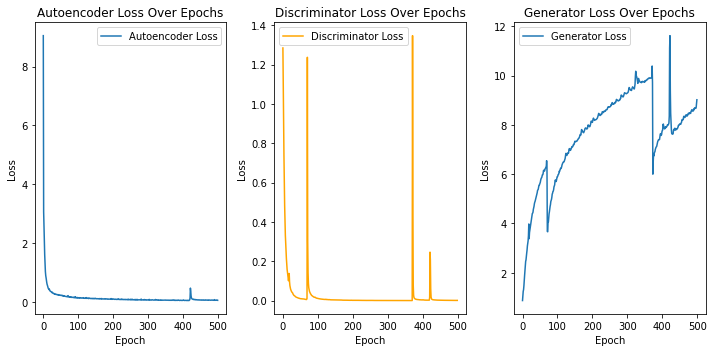

Training finished.
Moved model back to cpu.


In [50]:
num_epochs = 50

# Lists to store losses for plotting
all_losses_ae = []
all_losses_d = []
all_losses_ed = []

# Print the GPU device
print(f"Running on GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
# Training loop
for epoch in range(num_epochs):
    epoch_losses_ae = []
    epoch_losses_d = []
    epoch_losses_ed = []

    for batch in data_loader:
        inputs, targets = batch['input'].to(device), batch['target'].to(device)

        # Train autoencoder
        optimizer_ae.zero_grad()
        decoded, discriminated = aae_model(inputs)
        loss_ae = reconstruction_loss_fn(decoded, targets)
        loss_ae.backward()
        optimizer_ae.step()
        epoch_losses_ae.append(loss_ae.item())

        # Train discriminator
        optimizer_d.zero_grad()
        with torch.no_grad():
            encoded_fake = encoder(inputs).detach()
            encoded_true = torch.randn_like(encoded_fake).to(device)   # the true sample
        fake_output = discriminator(encoded_fake)
        true_output = discriminator(encoded_true)
        loss_d = adversarial_loss_fn(fake_output, torch.zeros_like(fake_output).to(device)) + \
                 adversarial_loss_fn(true_output, torch.ones_like(true_output).to(device))
        loss_d.backward()
        optimizer_d.step()
        epoch_losses_d.append(loss_d.item())

        # Train encoder/generator
        optimizer_ed.zero_grad()
        with torch.no_grad():
            encoded_fool = encoder(inputs).detach()
        fake_output = discriminator(encoded_fool)
        loss_ed = adversarial_loss_fn(fake_output, torch.ones_like(fake_output).to(device))
        loss_ed.backward()
        optimizer_ed.step()
        epoch_losses_ed.append(loss_ed.item())

    # Average losses over the epoch
    avg_loss_ae = sum(epoch_losses_ae) / len(epoch_losses_ae)
    avg_loss_d = sum(epoch_losses_d) / len(epoch_losses_d)
    avg_loss_ed = sum(epoch_losses_ed) / len(epoch_losses_ed)

    # Print the average loss at the end of each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], AE Loss: {avg_loss_ae:.4f}, D Loss: {avg_loss_d:.4f}, ED Loss: {avg_loss_ed:.4f}')

    # Record the losses for plotting
    all_losses_ae.append(avg_loss_ae)
    all_losses_d.append(avg_loss_d)
    all_losses_ed.append(avg_loss_ed)

# Plot the losses separately
plt.figure(figsize=(10, 5))

# Autoencoder Loss Plot
plt.subplot(1, 3, 1)
plt.plot(all_losses_ae, label='Autoencoder Loss')
plt.title('Autoencoder Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Discriminator Loss Plot
plt.subplot(1, 3, 2)
plt.plot(all_losses_d, label='Discriminator Loss', color='orange')
plt.title('Discriminator Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# ED Loss Plot
plt.subplot(1, 3, 3)
plt.plot(all_losses_ed, label='Generator Loss')
plt.title('Generator Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print("Training finished.")
aae_model = aae_model.cpu()
print("Moved model back to cpu.")

Running on GPU: GeForce RTX 2080 Ti
Epoch [1/300], AE Loss: 9.1306, D Loss: 1.3359, ED Loss: 0.8224, Val AE Loss: 3.6761
Epoch [2/300], AE Loss: 3.1976, D Loss: 1.1624, ED Loss: 0.9689, Val AE Loss: 2.5799
Epoch [3/300], AE Loss: 2.6767, D Loss: 0.9766, ED Loss: 1.1543, Val AE Loss: 2.4939
Epoch [4/300], AE Loss: 2.5670, D Loss: 0.7893, ED Loss: 1.2798, Val AE Loss: 2.4019
Epoch [5/300], AE Loss: 2.4003, D Loss: 0.6607, ED Loss: 1.3584, Val AE Loss: 2.0544
Epoch [6/300], AE Loss: 1.8468, D Loss: 0.5901, ED Loss: 1.5401, Val AE Loss: 1.4806
Epoch [7/300], AE Loss: 1.3905, D Loss: 0.4901, ED Loss: 1.7352, Val AE Loss: 1.1974
Epoch [8/300], AE Loss: 1.1141, D Loss: 0.4149, ED Loss: 1.8834, Val AE Loss: 0.9339
Epoch [9/300], AE Loss: 0.9492, D Loss: 0.3527, ED Loss: 2.0860, Val AE Loss: 0.8402
Epoch [10/300], AE Loss: 0.8496, D Loss: 0.2978, ED Loss: 2.2213, Val AE Loss: 0.7243
/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/PredictionModel/autoencoder_Flow_PredictionLatent_/checkpo

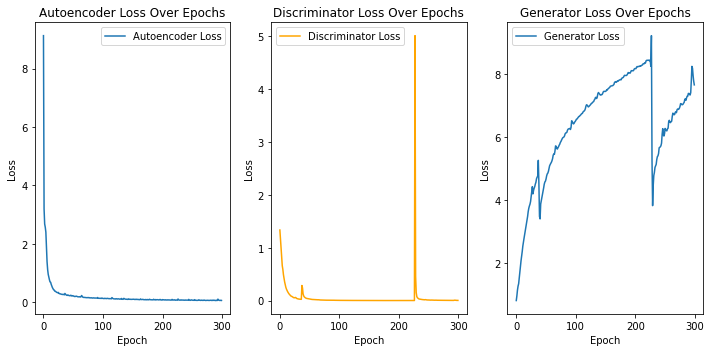

Training finished.
Moved model back to CPU.


In [86]:
# Set the checkpoint directory
checkpoint_dir = '/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/PredictionModel/autoencoder_Flow_PredictionLatent_'
os.makedirs(checkpoint_dir, exist_ok=True)

num_epochs = 300

# Set the checkpoint frequency (save every n epochs)
checkpoint_freq = 10

# Lists to store losses for plotting
all_losses_ae = []
all_losses_d = []
all_losses_ed = []
all_losses_ae_val = []

# Print the GPU device
print(f"Running on GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
# Training loop
for epoch in range(num_epochs):
    epoch_losses_ae = []
    epoch_losses_d = []
    epoch_losses_ed = []

    for batch in train_data_loader:
        inputs, targets = batch['input'].to(device), batch['target'].to(device)

        # Train autoencoder/predictor
        optimizer_ae.zero_grad()
        decoded, discriminated = aae_model(inputs)
        loss_ae = reconstruction_loss_fn(decoded, targets)
        loss_ae.backward()
        optimizer_ae.step()
        epoch_losses_ae.append(loss_ae.item())

        # Train encoder/generator
        optimizer_ed.zero_grad()
        encoded_fool = encoder(inputs)
        fake_output = discriminator(encoded_fool)
        loss_ed = adversarial_loss_fn(fake_output, torch.ones_like(fake_output).to(device))
        loss_ed.backward()
        optimizer_ed.step()
        epoch_losses_ed.append(loss_ed.item())

        # Train discriminator
        optimizer_d.zero_grad()
        encoded_fake = encoder(inputs).detach()
        encoded_true = torch.randn_like(encoded_fake).to(device)   # the true sample
        fake_output = discriminator(encoded_fake)
        true_output = discriminator(encoded_true)
        loss_d = adversarial_loss_fn(fake_output, torch.zeros_like(fake_output).to(device)) + \
                 adversarial_loss_fn(true_output, torch.ones_like(true_output).to(device))
        loss_d.backward()
        optimizer_d.step()
        epoch_losses_d.append(loss_d.item())
    
    # Validation phase
    with torch.no_grad():
        for val_batch in val_data_loader:  # Assuming you have a separate val_data_loader for validation
            val_inputs, val_targets = val_batch['input'].to(device), val_batch['target'].to(device)
            val_decoded, val_discriminated = aae_model(val_inputs)
            val_loss_ae = reconstruction_loss_fn(val_decoded, val_targets).item()
            val_loss_d = 0  # Adjust as needed for discriminator loss in validation
            val_loss_ed = 0  # Adjust as needed for encoder/generator loss in validation

            # Record validation losses
            all_losses_ae_val.append(val_loss_ae)

    # Average losses over the epoch
    avg_loss_ae = sum(epoch_losses_ae) / len(epoch_losses_ae)
    avg_loss_d = sum(epoch_losses_d) / len(epoch_losses_d)
    avg_loss_ed = sum(epoch_losses_ed) / len(epoch_losses_ed)
    avg_loss_ed_val = sum(all_losses_ae_val) / len(all_losses_ae_val)

    # Print the average loss at the end of each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], AE Loss: {avg_loss_ae:.4f}, D Loss: {avg_loss_d:.4f}, ED Loss: {avg_loss_ed:.4f}, Val AE Loss: {val_loss_ae:.4f}')

    # Record the losses for plotting
    all_losses_ae.append(avg_loss_ae)
    all_losses_d.append(avg_loss_d)
    all_losses_ed.append(avg_loss_ed)

    # Save checkpoint
    if (epoch + 1) % checkpoint_freq == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch + 1}.pth')
        print(checkpoint_path)
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': aae_model.state_dict(),
            'optimizer_ae_state_dict': optimizer_ae.state_dict(),
            'optimizer_d_state_dict': optimizer_d.state_dict(),
            'optimizer_ed_state_dict': optimizer_ed.state_dict(),
            'all_losses_ae': all_losses_ae,
            'all_losses_d': all_losses_d,
            'all_losses_ed': all_losses_ed,
            'all_losses_ae_val': all_losses_ae_val,
        }, checkpoint_path)
        print(f'Checkpoint saved at epoch {epoch + 1}.')

# Plot the losses separately
plt.figure(figsize=(10, 5))

# Autoencoder Loss Plot
plt.subplot(1, 3, 1)
plt.plot(all_losses_ae, label='Autoencoder Loss')
plt.title('Autoencoder Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Discriminator Loss Plot
plt.subplot(1, 3, 2)
plt.plot(all_losses_d, label='Discriminator Loss', color='orange')
plt.title('Discriminator Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# ED Loss Plot
plt.subplot(1, 3, 3)
plt.plot(all_losses_ed, label='Generator Loss')
plt.title('Generator Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print("Training finished.")
aae_model = aae_model.cpu()
print("Moved model back to CPU.")

### Save trained model

In [51]:
torch.save(aae_model.state_dict(), '/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/PredictionModel/autoencoder_Flow_PredictionLatent_{}epochs_{}batchsize_addBuilding_newoutputshape_1229.pth'.format(num_epochs, batch_size))  ### PredictionMulti

## Load saved model - checkpoint

In [25]:
checkpoint = torch.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/PredictionModel/autoencoder_Flow_PredictionLatent_/checkpoint_epoch_300.pth')

In [26]:
# Load the saved autoencoder
encoder = Encoder()
decoder = Decoder()
discriminator = Discriminator()
autoencoderP = AdversarialAutoencoder(encoder, decoder, discriminator)
# autoencoder.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/interpolation_code_example_2D/models/Velocity256_Compression_1000epochs_64batchsize_lr0.003_updatedLoss.pth'))
# autoencoder.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/interpolation_code_example_2D/models/Velocity256_Compression_1000epochs_32batchsize_lr0.003_updatedLoss.pth'))
# autoencoder.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/interpolation_code_example_2D/models/Velocity256_Compression_1000epochs_64batchsize_lr0.003_updatedLoss.pth'))


autoencoderP.load_state_dict(checkpoint['model_state_dict'])

autoencoderP.eval()  # Set the autoencoder to evaluation mode

aae_model = autoencoderP

In [72]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# the input size is (channels, height, width)
input_size = (ss_0.shape[1], ss_0.shape[2], ss_0.shape[3])

summary(autoencoderP.to(device), input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 96, 96]         258,304
         LeakyReLU-2          [-1, 256, 96, 96]               0
            Conv2d-3          [-1, 128, 96, 96]         295,040
         LeakyReLU-4          [-1, 128, 96, 96]               0
            Conv2d-5          [-1, 128, 96, 96]         147,584
         LeakyReLU-6          [-1, 128, 96, 96]               0
           Encoder-7          [-1, 128, 96, 96]               0
   ConvTranspose2d-8           [-1, 64, 96, 96]          73,728
         LeakyReLU-9           [-1, 64, 96, 96]               0
  ConvTranspose2d-10          [-1, 112, 96, 96]          64,512
         Identity-11          [-1, 112, 96, 96]               0
          Decoder-12          [-1, 112, 96, 96]               0
           Conv2d-13           [-1, 64, 96, 96]         204,864
             ReLU-14           [-1, 64,

## Load saved model - AAE

In [20]:
num_epochs = 10000
batch_size = 16


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(ss_0.shape[1], 256, kernel_size=(3, 3), stride=1, padding=1),
            nn.LeakyReLU(),

            nn.Conv2d(256, 128, kernel_size=(3, 3), stride=1, padding=1),
            nn.LeakyReLU(),

            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=1, padding=1),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=1, padding=1, output_padding=0, bias=False),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(64, ss_1.shape[1], kernel_size=(3, 3), stride=1, padding=1, output_padding=0, bias=False),
            nn.Identity()
        )

    def forward(self, x):
        return self.model(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 1, kernel_size=5, stride=1, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.discriminator(x)
    
# Adversarial Autoencoder (AAE)
class AdversarialAutoencoder(nn.Module):
    def __init__(self, encoder, decoder, discriminator):
        super(AdversarialAutoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        discriminated = self.discriminator(encoded)
        return decoded, discriminated

# Load the saved autoencoder
# Instantiate components
encoder = Encoder()
decoder = Decoder()
discriminator = Discriminator()
autoencoderP = AdversarialAutoencoder(encoder, decoder, discriminator)

autoencoderP.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/PredictionModel/autoencoder_Flow_PredictionLatent_10000epochs_AAEVen200Samples_3ts.pth'))

autoencoderP.eval()  # Set the autoencoder to evaluation mode

RuntimeError: Error(s) in loading state_dict for AdversarialAutoencoder:
	size mismatch for decoder.model.2.weight: copying a param with shape torch.Size([64, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 112, 3, 3]).

In [35]:
aae_model = autoencoderP

## Generate result plots

### Load CAE model

In [27]:
## for velocity
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU()
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.ConvTranspose2d(32, 2, kernel_size=2, stride=2, padding=0),   # Change kernel_size and stride to 2
            nn.Identity()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Load the saved autoencoder
autoencoder = Autoencoder()  # Assuming you have the ConvAutoencoder class defined
autoencoder.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/MainCodes/models/Velocity256_Compression_1500epochs_32batchsize_lr0.001_326464.pth'))

autoencoder.eval()  # Set the autoencoder to evaluation mode

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(2, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(32, 2, kernel_size=(2, 2), stride=(2, 2))
    (3): Identity()
  )
)

In [28]:
sample = samples_training_Y_stacked[1]
print(sample.shape)

(112, 96, 96)


In [29]:
input_data = torch.from_numpy(sample[:32,:,:]).unsqueeze(0).float()
print(input_data.shape)
res = autoencoder.decoder(input_data)
output_data = res.detach().numpy()
print(output_data.shape)

torch.Size([1, 32, 96, 96])
(1, 2, 384, 384)


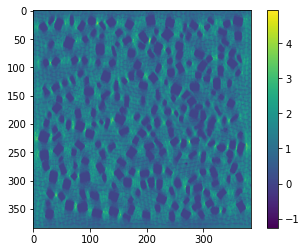

In [30]:
plt.figure()
plt.imshow(output_data[0,0])
cbar = plt.colorbar()

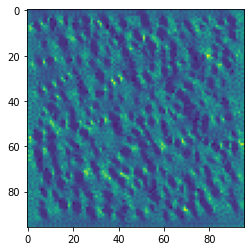

In [31]:
plt.imshow(samples_training_Y_stacked[0][16])

### Predict

In [32]:
id = 1
sampleX = torch.from_numpy((samples_training_X_stacked[id]).reshape(1,ss_0.shape[1],xysize_latent,xysize_latent)).float()
sampleTarget = torch.from_numpy((samples_training_Y_stacked[id]).reshape(1,ss_1.shape[1],xysize_latent,xysize_latent)).float()
print(sampleX.shape)
print(sampleTarget.shape)

torch.Size([1, 112, 96, 96])
torch.Size([1, 112, 96, 96])


In [33]:
with torch.no_grad():
    aae_model.eval().cpu()  # Set the model to evaluation mode
    prediction = aae_model(sampleX)

prediction = prediction[0]

torch.Size([1, 112, 96, 96])


(array([792089., 212227.,  15377.,   4047.,   1616.,   1888.,   1603.,
          1315.,   1194.,    836.]),
 array([ 0.       ,  2.4357257,  4.8714514,  7.3071775,  9.742903 ,
        12.178629 , 14.614355 , 17.050081 , 19.485806 , 21.921532 ,
        24.357258 ], dtype=float32),
 <BarContainer object of 10 artists>)

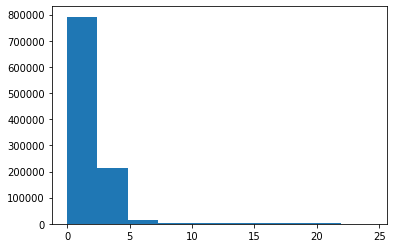

In [34]:
print(sampleTarget.shape)
plt.hist(sampleTarget.flatten())

torch.Size([1, 112, 96, 96])


(array([354362., 588487.,  73560.,   6814.,   1956.,   1906.,   1572.,
          1500.,   1284.,    751.]),
 array([-1.3962955,  1.1446714,  3.6856384,  6.2266054,  8.767572 ,
        11.308539 , 13.849506 , 16.390472 , 18.93144  , 21.472408 ,
        24.013374 ], dtype=float32),
 <BarContainer object of 10 artists>)

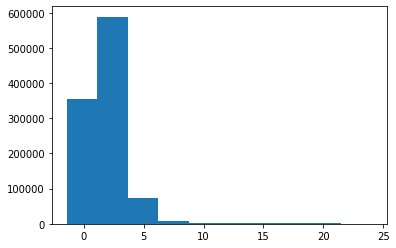

In [35]:
print(prediction.shape)
plt.hist(prediction.flatten())

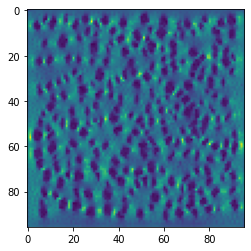

In [36]:
plt.imshow(prediction[0][4])

torch.Size([1, 32, 96, 96])
(1, 2, 384, 384)


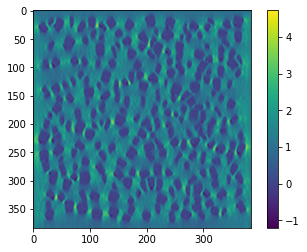

In [37]:
# input_data = torch.from_numpy(prediction).unsqueeze(0).float()
# input_data = prediction[:1, :, :, :]
input_data = prediction[:1, 64:96, :, :]
print(input_data.shape)
res = autoencoder.decoder(input_data)
output_data = res.detach().numpy()
print(output_data.shape)
plt.figure()
plt.imshow(output_data[0,0])
cbar = plt.colorbar()

In [38]:
def mse_loss(image1, image2):
    """
    Compute the Mean Squared Error (MSE) loss between two images.

    Parameters:
        - image1: NumPy array representing the first image
        - image2: NumPy array representing the second image

    Returns:
        - mse: MSE loss value
    """
    mse = np.mean((image1 - image2)**2)
    return mse


In [99]:
# Plot the results together

def plot_results_together(id_sample):
    velocity_field = 0

    sampleX = samples_training_X_stacked[id_sample]
    sampleY = samples_training_Y_stacked[id_sample]


    X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX[:32,:,:]).unsqueeze(0).float())
    X1_decoded = X1_decoded.detach().numpy()

    X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX[32:32+32,:,:]).unsqueeze(0).float())
    X2_decoded = X2_decoded.detach().numpy()

    Y_decoded = autoencoder.decoder(torch.from_numpy(sampleX[32+32:32+32+32,:,:]).unsqueeze(0).float())
    Y_decoded = Y_decoded.detach().numpy()

    # switch models here
    # prediction = autoencoderP(torch.from_numpy(sampleX).unsqueeze(0).float())
    prediction = aae_model(torch.from_numpy(sampleX).unsqueeze(0).float())[0]

    prediction_decoded = autoencoder.decoder(prediction[:1, 64:96, :, :])
    prediction_decoded = prediction_decoded.detach().numpy()


    loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
    print("prediction error:", loss)


    # plt.figure()

    # f, axarr = plt.subplots(1,4, figsize=(18, 9))

    # # plot latent space
    # sub1 = axarr[0][0].imshow(sampleX[0], interpolation='none')
    # axarr[0][0].title.set_text('Latent X1')

    # sub2 = axarr[0][1].imshow(sampleX[32], interpolation='none')
    # axarr[0][1].title.set_text('Latent X2')

    # sub3 = axarr[0][2].imshow(sampleY[0], interpolation='none')
    # axarr[0][2].title.set_text('Latent Y_Target')

    # sub4 = axarr[0][3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
    # axarr[0][3].title.set_text('Latent Y_Prediction')

    # # plot decoded space
    # sub11 = axarr[0].imshow(X1_decoded[0][velocity_field], interpolation='none')
    # axarr[0].title.set_text('X1')

    # sub12 = axarr[1].imshow(X2_decoded[0][velocity_field], interpolation='none')
    # axarr[1].title.set_text('X2')

    # sub13 = axarr[2].imshow(Y_decoded[0][velocity_field], interpolation='none')
    # axarr[2].title.set_text('Y_Target')

    # sub14 = axarr[3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
    # axarr[3].title.set_text('Y_Prediction')

In [65]:
for i in range(1,60,1):
    plot_results_together(i)

prediction error: 0.021623768
prediction error: 0.02159787
prediction error: 0.021292534
prediction error: 0.021139538
prediction error: 0.02105254
prediction error: 0.02100256
prediction error: 0.020935725
prediction error: 0.02090235
prediction error: 0.020902906
prediction error: 0.02095474
prediction error: 0.021021573
prediction error: 0.021142252
prediction error: 0.02130367
prediction error: 0.021459945
prediction error: 0.021620322
prediction error: 0.021760156
prediction error: 0.021931801
prediction error: 0.02210791
prediction error: 0.0223057
prediction error: 0.022555122
prediction error: 0.022810727
prediction error: 0.02307386
prediction error: 0.023307476
prediction error: 0.023506701
prediction error: 0.023712508
prediction error: 0.023947736
prediction error: 0.024225738
prediction error: 0.024501558
prediction error: 0.024800852
prediction error: 0.025119074
prediction error: 0.025461733
prediction error: 0.025785048
prediction error: 0.026100552
prediction error: 0.

In [66]:
for i in range(1,60,1):
    plot_results_together(i)

prediction error: 0.021623768
prediction error: 0.02159787
prediction error: 0.021292534
prediction error: 0.021139538
prediction error: 0.02105254
prediction error: 0.02100256
prediction error: 0.020935725
prediction error: 0.02090235
prediction error: 0.020902906
prediction error: 0.02095474
prediction error: 0.021021573
prediction error: 0.021142252
prediction error: 0.02130367
prediction error: 0.021459945
prediction error: 0.021620322
prediction error: 0.021760156
prediction error: 0.021931801
prediction error: 0.02210791
prediction error: 0.0223057
prediction error: 0.022555122
prediction error: 0.022810727
prediction error: 0.02307386
prediction error: 0.023307476
prediction error: 0.023506701
prediction error: 0.023712508
prediction error: 0.023947736
prediction error: 0.024225738
prediction error: 0.024501558
prediction error: 0.024800852
prediction error: 0.025119074
prediction error: 0.025461733
prediction error: 0.025785048
prediction error: 0.026100552
prediction error: 0.

### Predict for test

In [67]:
n_sampels = 10
t_gaps_sampels = 2
dt = 5
ntimes = 3

batch_size = 1  # Choose your desired batch size

samples_test = []
samples_test_X = []
samples_test_Y = []

for i in range(1, n_sampels+1):
    ii = 1 + i*t_gaps_sampels
    # s = np.concatenate([Latent_data_VelocityXs_test[ss] for ss in range(ii,ii + dt*ntimes, dt )], axis = 0)
    s = np.stack([Latent_data_Velocity_test[ss] for ss in range(ii,ii + dt*ntimes, dt )])
    s_building = Latent_data_Building
    # ss_0 = np.concatenate((s[0].reshape(1, 32, xysize_latent, xysize_latent), s_building), axis=1)   # X
    ss_0 = np.concatenate((s[0].reshape(1, 32, xysize_latent, xysize_latent), s[1].reshape(1, 32, xysize_latent, xysize_latent), s[2].reshape(1, 32, xysize_latent, xysize_latent), s_building), axis=1)   # X

    # ss_1 = s[2].reshape(1, 32, xysize_latent, xysize_latent)   # Y
    ss_1 = ss_0


    ss = (ss_0, ss_1)
    print(ss[0].shape)
    print(ss[1].shape)
    samples_test.append(ss)
    samples_test_X.append(ss_0)
    samples_test_Y.append(ss_1)


samples_test_X_stacked = (np.stack(samples_test_X)).reshape(n_sampels, ss_0.shape[1], xysize_latent, xysize_latent)
print(samples_test_X_stacked.shape)

samples_test_Y_stacked = (np.stack(samples_test_Y)).reshape(n_sampels, ss_1.shape[1], xysize_latent, xysize_latent)
print(samples_test_Y_stacked.shape)

(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(1, 112, 96, 96)
(10, 112, 96, 96)
(10, 112, 96, 96)


In [68]:
autoencoderP = aae_model

In [69]:
# Plot the results together

def plot_results_together(id_sample, velocity_field):
    velocity_field = velocity_field

    sampleX = samples_test_X_stacked[id_sample]
    sampleY = samples_test_Y_stacked[id_sample]


    X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX[:32,:,:]).unsqueeze(0).float())
    X1_decoded = X1_decoded.detach().numpy()

    X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX[32:32+32,:,:]).unsqueeze(0).float())
    X2_decoded = X2_decoded.detach().numpy()

    Y_decoded = autoencoder.decoder(torch.from_numpy(sampleY[64:96,:,:]).unsqueeze(0).float())
    Y_decoded = Y_decoded.detach().numpy()

    # switch models here
    # prediction = autoencoderP(torch.from_numpy(sampleX).unsqueeze(0).float())
    prediction = autoencoderP(torch.from_numpy(sampleX).unsqueeze(0).float())[0]

    prediction_decoded = autoencoder.decoder(prediction[:1, 64:96, :, :])
    prediction_decoded = prediction_decoded.detach().numpy()


    loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
    print("prediction error:", loss)


    # plt.figure()

    # f, axarr = plt.subplots(2,4, figsize=(18, 9))

    # # plot latent space
    # sub1 = axarr[0][0].imshow(sampleX[0], interpolation='none')
    # axarr[0][0].title.set_text('Latent X1')

    # sub2 = axarr[0][1].imshow(sampleX[32], interpolation='none')
    # axarr[0][1].title.set_text('Latent X2')

    # sub3 = axarr[0][2].imshow(sampleY[0], interpolation='none')
    # axarr[0][2].title.set_text('Latent Y_Target')

    # sub4 = axarr[0][3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
    # axarr[0][3].title.set_text('Latent Y_Prediction')

    # # plot decoded space
    # sub11 = axarr[1][0].imshow(X1_decoded[0][velocity_field], interpolation='none')
    # axarr[1][0].title.set_text('X1')

    # sub12 = axarr[1][1].imshow(X2_decoded[0][velocity_field], interpolation='none')
    # axarr[1][1].title.set_text('X2')

    # sub13 = axarr[1][2].imshow(Y_decoded[0][velocity_field], interpolation='none')
    # axarr[1][2].title.set_text('Y_Target')

    # sub14 = axarr[1][3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
    # axarr[1][3].title.set_text('Y_Prediction')

In [70]:
for i in range(1,10):
    plot_results_together(i, 1)

prediction error: 0.05373604
prediction error: 0.053859763
prediction error: 0.05408683
prediction error: 0.05433254
prediction error: 0.05456784
prediction error: 0.054680556
prediction error: 0.054599088
prediction error: 0.054809693
prediction error: 0.054482486


In [ ]:
for i in range(1,10):
    plot_results_together(i, 0)

# Predict iteratively

In [100]:
autoencoderP = aae_model

prediction error: 0.024812328


<Figure size 432x288 with 0 Axes>

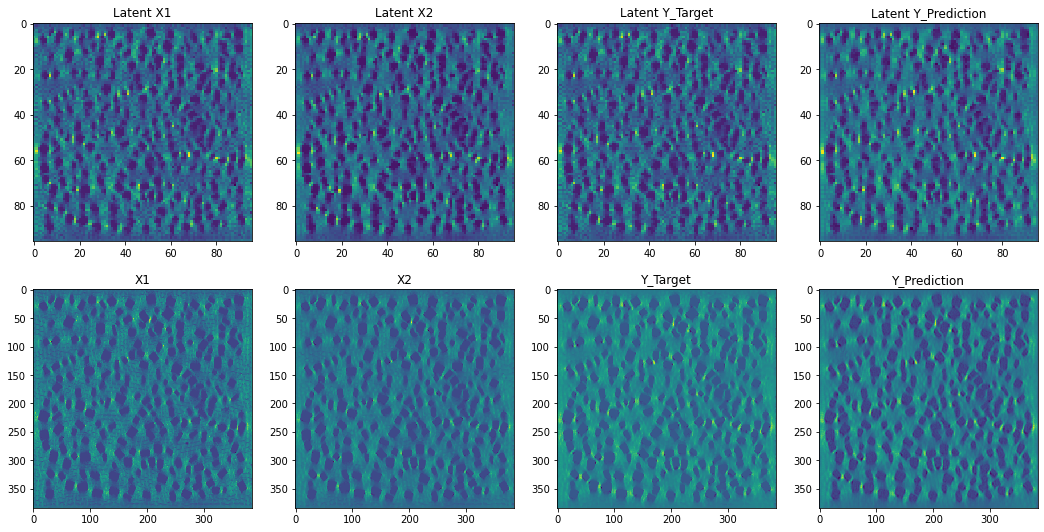

In [101]:
id_sample = 1

velocity_field = 0

sampleX = samples_training_X_stacked[id_sample]
sampleY = samples_training_Y_stacked[id_sample]


X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX[:32,:,:]).unsqueeze(0).float())
X1_decoded = X1_decoded.detach().numpy()

X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX[32:32+32,:,:]).unsqueeze(0).float())
X2_decoded = X2_decoded.detach().numpy()

Y_decoded = autoencoder.decoder(torch.from_numpy(sampleX[32+32:32+32+32,:,:]).unsqueeze(0).float())
Y_decoded = Y_decoded.detach().numpy()

prediction = autoencoderP(torch.from_numpy(sampleX).unsqueeze(0).float())[0]

prediction_decoded = autoencoder.decoder(prediction[:1, 64:96, :, :])
prediction_decoded = prediction_decoded.detach().numpy()


loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
print("prediction error:", loss)


plt.figure()

f, axarr = plt.subplots(2,4, figsize=(18, 9))

# plot latent space
sub1 = axarr[0][0].imshow(sampleX[0], interpolation='none')
axarr[0][0].title.set_text('Latent X1')

sub2 = axarr[0][1].imshow(sampleX[32], interpolation='none')
axarr[0][1].title.set_text('Latent X2')

sub3 = axarr[0][2].imshow(sampleY[0], interpolation='none')
axarr[0][2].title.set_text('Latent Y_Target')

sub4 = axarr[0][3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
axarr[0][3].title.set_text('Latent Y_Prediction')

# plot decoded space
sub11 = axarr[1][0].imshow(X1_decoded[0][velocity_field], interpolation='none')
axarr[1][0].title.set_text('X1')

sub12 = axarr[1][1].imshow(X2_decoded[0][velocity_field], interpolation='none')
axarr[1][1].title.set_text('X2')

sub13 = axarr[1][2].imshow(Y_decoded[0][velocity_field], interpolation='none')
axarr[1][2].title.set_text('Y_Target')

sub14 = axarr[1][3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
axarr[1][3].title.set_text('Y_Prediction')

In [102]:
losses = []
losses_2pts_latent = []
n_iters = 50



id_sample = 1

velocity_field = 0

sampleX = samples_training_X_stacked[id_sample]
sampleY = samples_training_Y_stacked[id_sample]


X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX[:32,:,:]).unsqueeze(0).float())
X1_decoded = X1_decoded.detach().numpy()

X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX[32:32+32,:,:]).unsqueeze(0).float())
X2_decoded = X2_decoded.detach().numpy()

Y_decoded = autoencoder.decoder(torch.from_numpy(sampleX[32+32:32+32+32,:,:]).unsqueeze(0).float())
Y_decoded = Y_decoded.detach().numpy()

sampleX[32+32:32+32+32,:,:] = sampleX[32:32+32,:,:]
prediction = autoencoderP(torch.from_numpy(sampleX).unsqueeze(0).float())[0]

prediction_decoded = autoencoder.decoder(prediction[:1, 64:96, :, :])
prediction_decoded = prediction_decoded.detach().numpy()


loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
print("prediction error:", loss)
losses.append(loss)

loss_2pts_latent = mse_loss(prediction[:1, :64, :, :].detach().numpy(), sampleX[:64,:,:])
losses_2pts_latent.append(loss_2pts_latent)

# plt.figure()

# f, axarr = plt.subplots(2,4, figsize=(18, 9))

# # plot latent space
# sub1 = axarr[0][0].imshow(sampleX[0], interpolation='none')
# axarr[0][0].title.set_text('Latent X1')

# sub2 = axarr[0][1].imshow(sampleX[32], interpolation='none')
# axarr[0][1].title.set_text('Latent X2')

# sub3 = axarr[0][2].imshow(sampleY[0], interpolation='none')
# axarr[0][2].title.set_text('Latent Y_Target')

# sub4 = axarr[0][3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
# axarr[0][3].title.set_text('Latent Y_Prediction')

# # plot decoded space
# sub11 = axarr[1][0].imshow(X1_decoded[0][velocity_field], interpolation='none')
# axarr[1][0].title.set_text('X1')

# sub12 = axarr[1][1].imshow(X2_decoded[0][velocity_field], interpolation='none')
# axarr[1][1].title.set_text('X2')

# sub13 = axarr[1][2].imshow(Y_decoded[0][velocity_field], interpolation='none')
# axarr[1][2].title.set_text('Y_Target')

# sub14 = axarr[1][3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
# axarr[1][3].title.set_text('Y_Prediction')

prediction_new = prediction


for i in range(n_iters):

    sampleX = samples_training_X_stacked[id_sample]
    sampleX_new = sampleX.copy()
    prediction = prediction_new.detach().numpy()
    sampleX_new[64:64+32] = prediction[0,64:64+32]

    prediction_new = autoencoderP(torch.from_numpy(sampleX_new).unsqueeze(0).float())[0]

    prediction_decoded = autoencoder.decoder(prediction_new[:1, 64:64+32, :, :])
    prediction_decoded = prediction_decoded.detach().numpy()

    loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
    print("prediction error:", loss)
    losses.append(loss)

    loss_2pts_latent = mse_loss(prediction_new[:1, :64, :, :].detach().numpy(), sampleX[:64,:,:])
    losses_2pts_latent.append(loss_2pts_latent)

    # plt.figure()

    # f, axarr = plt.subplots(2,4, figsize=(18, 9))

    # # plot latent space
    # sub1 = axarr[0][0].imshow(sampleX[0], interpolation='none')
    # axarr[0][0].title.set_text('Latent X1')

    # sub2 = axarr[0][1].imshow(sampleX[32], interpolation='none')
    # axarr[0][1].title.set_text('Latent X2')

    # sub3 = axarr[0][2].imshow(sampleX_new[64], interpolation='none')
    # axarr[0][2].title.set_text('Latent Y_Target')

    # sub4 = axarr[0][3].imshow((prediction_new.detach().numpy())[0][0], interpolation='none')
    # axarr[0][3].title.set_text('Latent Y_Prediction')

    # # plot decoded space
    # sub11 = axarr[1][0].imshow(X1_decoded[0][velocity_field], interpolation='none')
    # axarr[1][0].title.set_text('X1')

    # sub12 = axarr[1][1].imshow(X2_decoded[0][velocity_field], interpolation='none')
    # axarr[1][1].title.set_text('X2')

    # sub13 = axarr[1][2].imshow(Y_decoded[0][velocity_field], interpolation='none')
    # axarr[1][2].title.set_text('Y_Target')

    # sub14 = axarr[1][3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
    # axarr[1][3].title.set_text('Y_Prediction')

prediction error: 0.05016493
prediction error: 0.050497174
prediction error: 0.05185016
prediction error: 0.053669687
prediction error: 0.055680983


prediction error: 0.057737
prediction error: 0.05975047
prediction error: 0.061666496
prediction error: 0.06345735
prediction error: 0.06511013
prediction error: 0.06662205
prediction error: 0.067995824
prediction error: 0.069238506
prediction error: 0.07035883
prediction error: 0.071366295
prediction error: 0.07227126
prediction error: 0.07308334
prediction error: 0.073811755
prediction error: 0.07446483
prediction error: 0.0750505
prediction error: 0.075575836
prediction error: 0.07604716
prediction error: 0.076470345
prediction error: 0.07685042
prediction error: 0.0771918
prediction error: 0.07749868
prediction error: 0.07777468
prediction error: 0.07802312
prediction error: 0.07824707
prediction error: 0.07844916
prediction error: 0.07863164
prediction error: 0.0787965
prediction error: 0.07894556
prediction error: 0.07908041
prediction error: 0.079202525
prediction error: 0.079313174
prediction error: 0.0794135
prediction error: 0.07950461
prediction error: 0.07958738
prediction 

In [103]:
print(len(losses))

51


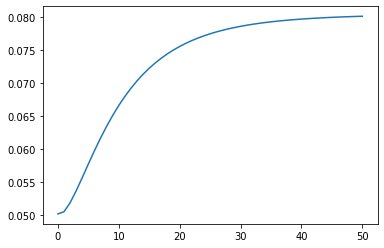

In [114]:
plt.plot(losses[:])

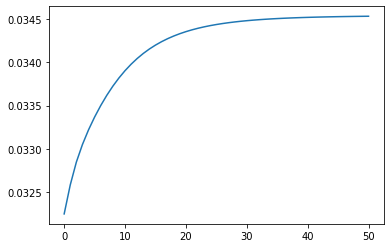

In [113]:
plt.plot(losses_2pts_latent[:])

# Time stepping - predict forward in time

In [39]:
def mse_loss(image1, image2):
    """
    Compute the Mean Squared Error (MSE) loss between two images.

    Parameters:
        - image1: NumPy array representing the first image
        - image2: NumPy array representing the second image

    Returns:
        - mse: MSE loss value
    """
    mse = np.mean((image1 - image2)**2)
    return mse


In [40]:
def run_iteration(sample_input, n_iters=25):

    SampleX = sample_input.clone()

    losses_2pts_latent = []

    prediction = autoencoderP(SampleX.float())[0]

    loss_2pts_latent = mse_loss(prediction[:1, :64, :, :].detach().numpy(), SampleX[:1, :64, :, :].detach().numpy())
    losses_2pts_latent.append(loss_2pts_latent)

    prediction_new = prediction

    for i in range(n_iters):
        sampleX_new = sample_input.clone()
        prediction = prediction_new
        # print(sampleX_new.shape)
        # print(prediction.shape)
        sampleX_new[0, 64:64 + 32] = prediction[0, 64:64 + 32]

        prediction_new = autoencoderP(sampleX_new.float())[0]
    
        loss_2pts_latent = mse_loss(prediction_new[:1, :64, :, :].detach().numpy(), SampleX[:1, :64, :, :].detach().numpy())
        losses_2pts_latent.append(loss_2pts_latent)

    return prediction_new, losses_2pts_latent

prediction error: 0.07731035
prediction error: 0.2561319
prediction error: 0.42634714
prediction error: 0.5749956
prediction error: 0.71034247
prediction error: 0.8288723
prediction error: 0.93905044
prediction error: 1.0505364
prediction error: 1.1656605
prediction error: 1.2962689
prediction error: 1.4478173
prediction error: 1.6153295
prediction error: 1.8043548
prediction error: 2.0385282
prediction error: 2.3794434
prediction error: 2.8476033
prediction error: 3.4778333
prediction error: 4.3250904
prediction error: 5.470587
prediction error: 6.890385
prediction error: 8.646416
prediction error: 10.718655
prediction error: 12.98576
prediction error: 15.587799
prediction error: 18.69976
prediction error: 22.216125
prediction error: 26.406584
prediction error: 31.470615
prediction error: 36.84642
prediction error: 43.11419
prediction error: 50.195873
prediction error: 56.468758
prediction error: 61.672287
prediction error: 67.60303
prediction error: 78.12912
prediction error: 89.8054

<Figure size 432x288 with 0 Axes>

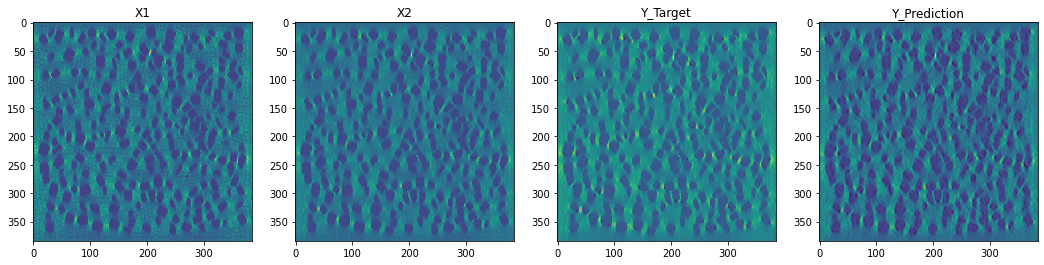

In [56]:
# can change run_iteration to autoencoderP

num_time_stepping = 50
velocity_field = 0
id_sample = 1

Samples_Ytargets = []
Samples_Predictions = []

sensor_values_X1 = []
sensor_values_X2 = []
sensor_values_Ytarget = []
sensor_values_prediction = []

timelevels = []

hist_data_predictions = []
hist_data_ground_truth = []
fft_data_predictions = []
fft_data_ground_truth = []

sampleX = samples_training_X_stacked[id_sample]
sampleY = samples_training_X_stacked[id_sample]


X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX[:32,:,:]).unsqueeze(0).float())
X1_decoded = X1_decoded.detach().numpy()

X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX[32:32+32,:,:]).unsqueeze(0).float())
X2_decoded = X2_decoded.detach().numpy()

Y_decoded = autoencoder.decoder(torch.from_numpy(sampleY[32+32:32+32+32,:,:]).unsqueeze(0).float())
Y_decoded = Y_decoded.detach().numpy()

prediction = run_iteration(torch.from_numpy(sampleX).unsqueeze(0).float())[0]

prediction_decoded = autoencoder.decoder(prediction[:1, 32+32:32+32+32, :, :])
prediction_decoded = prediction_decoded.detach().numpy()


Samples_Ytargets.append(Y_decoded)
Samples_Predictions.append(prediction_decoded)

# get histogram
hist_prediction, bins_prediction = np.histogram(prediction_decoded.flatten(), bins=50)
hist_ground_truth, bins_ground_truth = np.histogram(Y_decoded.flatten(), bins=50)

hist_data_predictions.append((hist_prediction, bins_prediction))
hist_data_ground_truth.append((hist_ground_truth, bins_ground_truth))

# get FFT
fft_prediction = np.fft.fft(prediction_decoded.flatten())
fft_ground_truth = np.fft.fft(Y_decoded.flatten())

fft_data_predictions.append(fft_prediction)
fft_data_ground_truth.append(fft_ground_truth)

# get sensor data
sensor_values_prediction.append(prediction_decoded[0,velocity_field, sensors_x, sensors_y])
sensor_values_X1.append(X1_decoded[0,velocity_field, sensors_x, sensors_y])
sensor_values_X2.append(X2_decoded[0,velocity_field, sensors_x, sensors_y])
sensor_values_Ytarget.append(Y_decoded[0,velocity_field, sensors_x, sensors_y])

loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
print("prediction error:", loss)

timelevel = id_sample*t_gaps_sampels + dt*2 # for training

timelevels.append(timelevel)

plt.figure()

f, axarr = plt.subplots(1,4, figsize=(18, 9))

# plot latent space
# sub1 = axarr[0].imshow(sampleX[0], interpolation='none')
# axarr[0].title.set_text('Latent X1')

# sub2 = axarr[1].imshow(sampleX[32], interpolation='none')
# axarr[1].title.set_text('Latent X2')

# sub3 = axarr[2].imshow(sampleY[0], interpolation='none')
# axarr[2].title.set_text('Latent Y_Target')

# sub4 = axarr[3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
# axarr[3].title.set_text('Latent Y_Prediction')

# plot decoded space
sub11 = axarr[0].imshow(X1_decoded[0][velocity_field], interpolation='none')
axarr[0].title.set_text('X1')

sub12 = axarr[1].imshow(X2_decoded[0][velocity_field], interpolation='none')
axarr[1].title.set_text('X2')

sub13 = axarr[2].imshow(Y_decoded[0][velocity_field], interpolation='none')
axarr[2].title.set_text('Y_Target')

sub14 = axarr[3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
axarr[3].title.set_text('Y_Prediction')


for n in range(num_time_stepping):    
    sampleX_new = sampleX.copy()
    sampleX_new[:32] = sampleX[32:64]
    sampleX_new[32:64] = (prediction.detach().numpy())[0, 64:96]
    sampleX_new[64:96] = sampleX_new[32:64]

    sampleY_new = Latent_data_Velocity_training[1 + id_sample*t_gaps_sampels + dt*(4 + n)]

    X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX_new[:32,:,:]).unsqueeze(0).float())
    X1_decoded = X1_decoded.detach().numpy()

    X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX_new[32:32+32,:,:]).unsqueeze(0).float())
    X2_decoded = X2_decoded.detach().numpy()

    Y_decoded = autoencoder.decoder(torch.from_numpy(sampleY_new[:,:,:]).unsqueeze(0).float())
    Y_decoded = Y_decoded.detach().numpy()

    prediction = run_iteration(torch.from_numpy(sampleX_new).unsqueeze(0).float())[0]

    prediction_decoded = autoencoder.decoder(prediction[:1, 64:96, :, :])
    prediction_decoded = prediction_decoded.detach().numpy()
    
    Samples_Ytargets.append(Y_decoded)
    Samples_Predictions.append(prediction_decoded)

    # get histogram
    hist_prediction, bins_prediction = np.histogram(prediction_decoded.flatten(), bins=50)
    hist_ground_truth, bins_ground_truth = np.histogram(Y_decoded.flatten(), bins=50)

    hist_data_predictions.append((hist_prediction, bins_prediction))
    hist_data_ground_truth.append((hist_ground_truth, bins_ground_truth))

    # get FFT
    fft_prediction = np.fft.fft(prediction_decoded.flatten())
    fft_ground_truth = np.fft.fft(Y_decoded.flatten())

    fft_data_predictions.append(fft_prediction)
    fft_data_ground_truth.append(fft_ground_truth)

    # get sensor data
    sensor_values_prediction.append(prediction_decoded[0,velocity_field, sensors_x, sensors_y])
    sensor_values_X1.append(X1_decoded[0,velocity_field, sensors_x, sensors_y])
    sensor_values_X2.append(X2_decoded[0,velocity_field, sensors_x, sensors_y])
    sensor_values_Ytarget.append(Y_decoded[0,velocity_field, sensors_x, sensors_y])

    timelevel = timelevel + dt
    timelevels.append(timelevel)


    loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
    print("prediction error:", loss)


    # plt.figure()

    # f, axarr = plt.subplots(1,4, figsize=(18, 9))

    # # plot latent space
    # sub1 = axarr[0].imshow(sampleX_new[0], interpolation='none')
    # axarr[0].title.set_text('Latent X1')

    # sub2 = axarr[1].imshow(sampleX_new[32], interpolation='none')
    # axarr[1].title.set_text('Latent X2')

    # sub3 = axarr[2].imshow(sampleY_new[0], interpolation='none')
    # axarr[2].title.set_text('Latent Y_Target')

    # sub4 = axarr[3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
    # axarr[3].title.set_text('Latent Y_Prediction')

    # plot decoded space
    # sub11 = axarr[0].imshow(X1_decoded[0][velocity_field], interpolation='none')
    # axarr[0].title.set_text('X1')

    # sub12 = axarr[1].imshow(X2_decoded[0][velocity_field], interpolation='none')
    # axarr[1].title.set_text('X2')

    # sub13 = axarr[2].imshow(Y_decoded[0][velocity_field], interpolation='none')
    # axarr[2].title.set_text('Y_Target')

    # sub14 = axarr[3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
    # axarr[3].title.set_text('Y_Prediction')


    sampleX = sampleX_new.copy()

In [57]:
print(len(Samples_Ytargets))
print(len(Samples_Predictions))

print(len(sensor_values_prediction))
print(len(sensor_values_X1))
print(len(sensor_values_X2))
print(len(sensor_values_Ytarget))
print(len(timelevels))

51
51
51
51
51
51
51


In [58]:
print(Samples_Predictions[0].shape)
print(Samples_Ytargets[0].shape)

numpy_array_Samples_Predictions = np.squeeze(np.stack(Samples_Predictions), axis = 1)
numpy_array_Samples_Ytargets = np.squeeze(np.stack(Samples_Ytargets), axis = 1)

print(numpy_array_Samples_Predictions.shape)
print(numpy_array_Samples_Ytargets.shape)

(1, 2, 384, 384)
(1, 2, 384, 384)
(51, 2, 384, 384)
(51, 2, 384, 384)


In [59]:
numpy_array_prediction = np.array(sensor_values_prediction)
numpy_array_X1 = np.array(sensor_values_X1)
numpy_array_X2 = np.array(sensor_values_X2)
numpy_array_Ytarget = np.array(sensor_values_Ytarget)
numpy_array_timelevels = np.array(timelevels)

# Print the shape of each NumPy array
print("Shape of numpy_array_prediction:", numpy_array_prediction.shape)
print("Shape of numpy_array_X1:", numpy_array_X1.shape)
print("Shape of numpy_array_X2:", numpy_array_X2.shape)
print("Shape of numpy_array_Ytarget:", numpy_array_Ytarget.shape)
print("Shape of numpy_array_timelevels:", numpy_array_timelevels.shape)

Shape of numpy_array_prediction: (51, 10)
Shape of numpy_array_X1: (51, 10)
Shape of numpy_array_X2: (51, 10)
Shape of numpy_array_Ytarget: (51, 10)
Shape of numpy_array_timelevels: (51,)


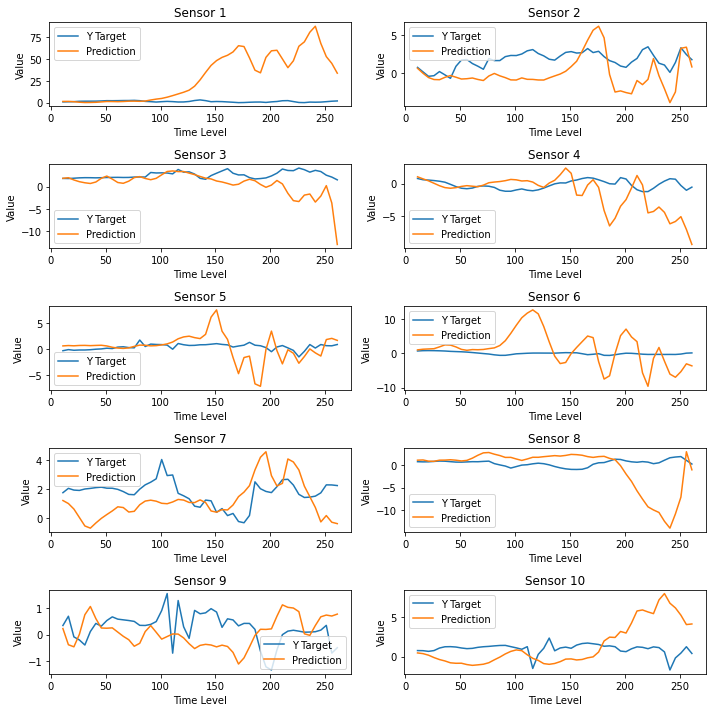

In [60]:
# Create a figure with 10 subplots
fig, axs = plt.subplots(5, 2, figsize=(10, 10))

# Iterate through the samples and create subplots
for i in range(10):
    # Select the i-th sample
    y_target_sample = numpy_array_Ytarget[:, i]
    prediction_sample = numpy_array_prediction[:, i]

    # Determine the subplot position
    row = i // 2
    col = i % 2
    # Plot Y target and prediction in the subplot
    axs[row, col].plot(numpy_array_timelevels, y_target_sample, label='Y Target')
    axs[row, col].plot(numpy_array_timelevels, prediction_sample, label='Prediction')
    axs[row, col].set_title(f'Sensor {i+1}')
    axs[row, col].set_xlabel('Time Level')
    axs[row, col].set_ylabel('Value')
    axs[row, col].legend()

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

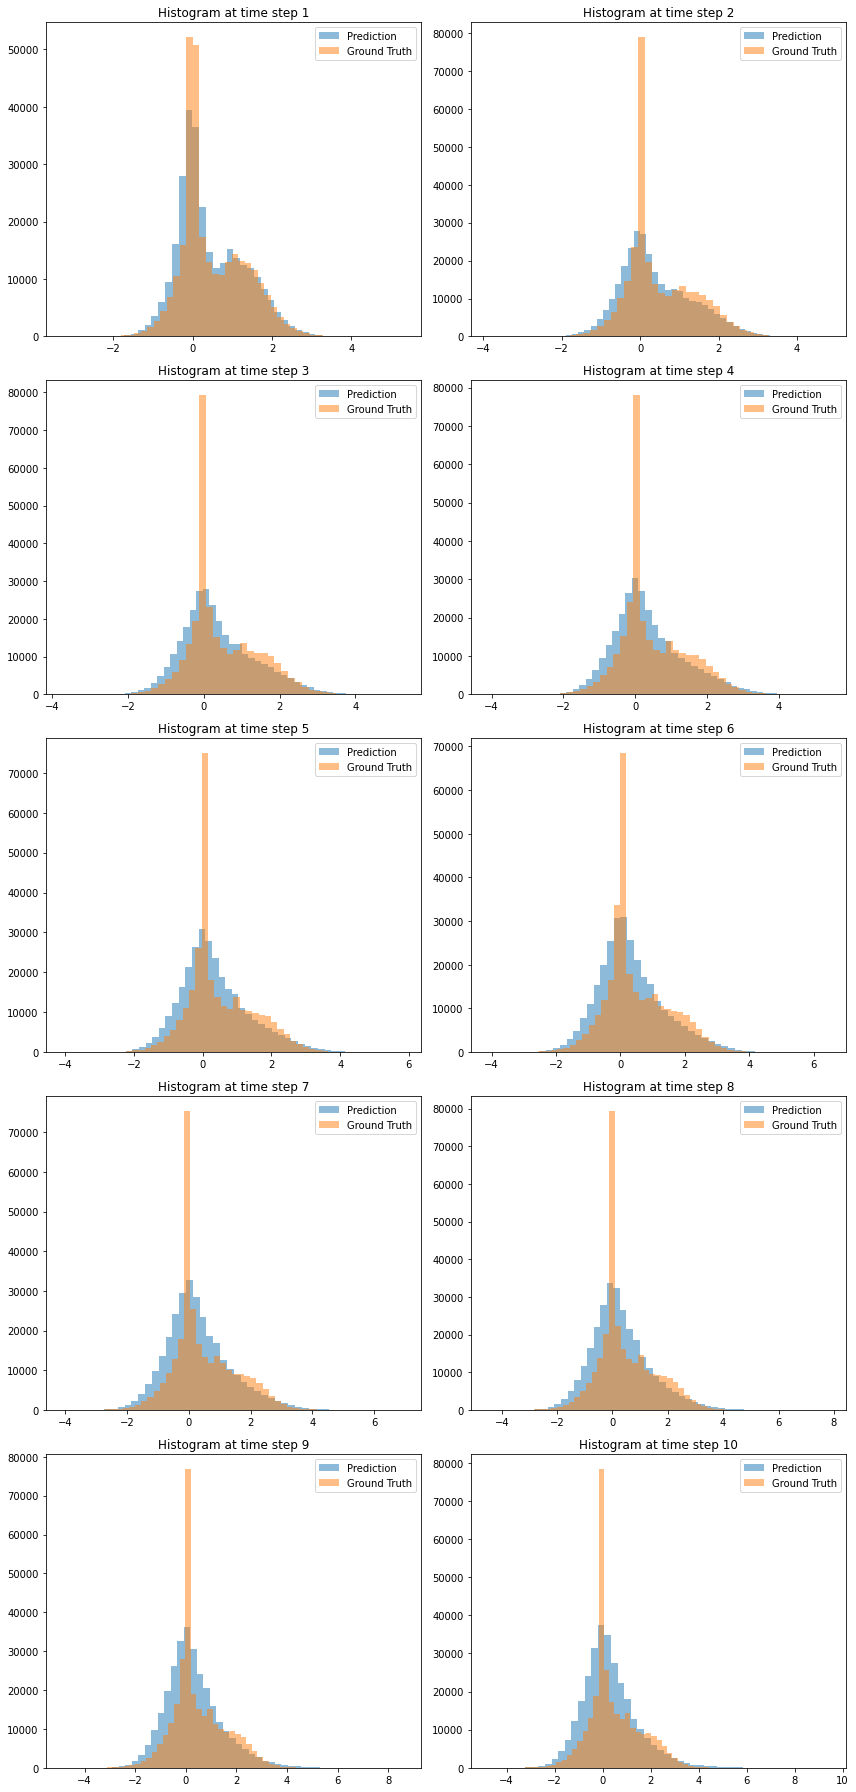

In [70]:
# Calculate the number of rows for the subplots
n = len(hist_data_predictions[:10])
cols = 2
rows = n // cols + (n % cols > 0)

# Create a new figure and a grid of subplots
fig, axs = plt.subplots(rows, cols, figsize=(12, 25))

# Flatten the axs array in case we have only one row
axs = axs.flatten()

# Iterate over all subplots and plot the histograms
for i, ax in enumerate(axs):
    if i < n:
        hist_prediction, bins_prediction = hist_data_predictions[i]
        hist_ground_truth, bins_ground_truth = hist_data_ground_truth[i]

        bin_centers_prediction = (bins_prediction[:-1] + bins_prediction[1:]) / 2
        bin_centers_ground_truth = (bins_ground_truth[:-1] + bins_ground_truth[1:]) / 2

        ax.bar(bin_centers_prediction, hist_prediction, width=np.diff(bins_prediction), alpha=0.5, label='Prediction')
        ax.bar(bin_centers_ground_truth, hist_ground_truth, width=np.diff(bins_ground_truth), alpha=0.5, label='Ground Truth')
        ax.legend(loc='upper right')
        ax.set_title('Histogram at time step ' + str(i + 1))
    else:
        # If there is no data, hide the extra subplots
        ax.axis('off')

# Adjust the spacing between subplots and display the figure
plt.tight_layout()
plt.show()

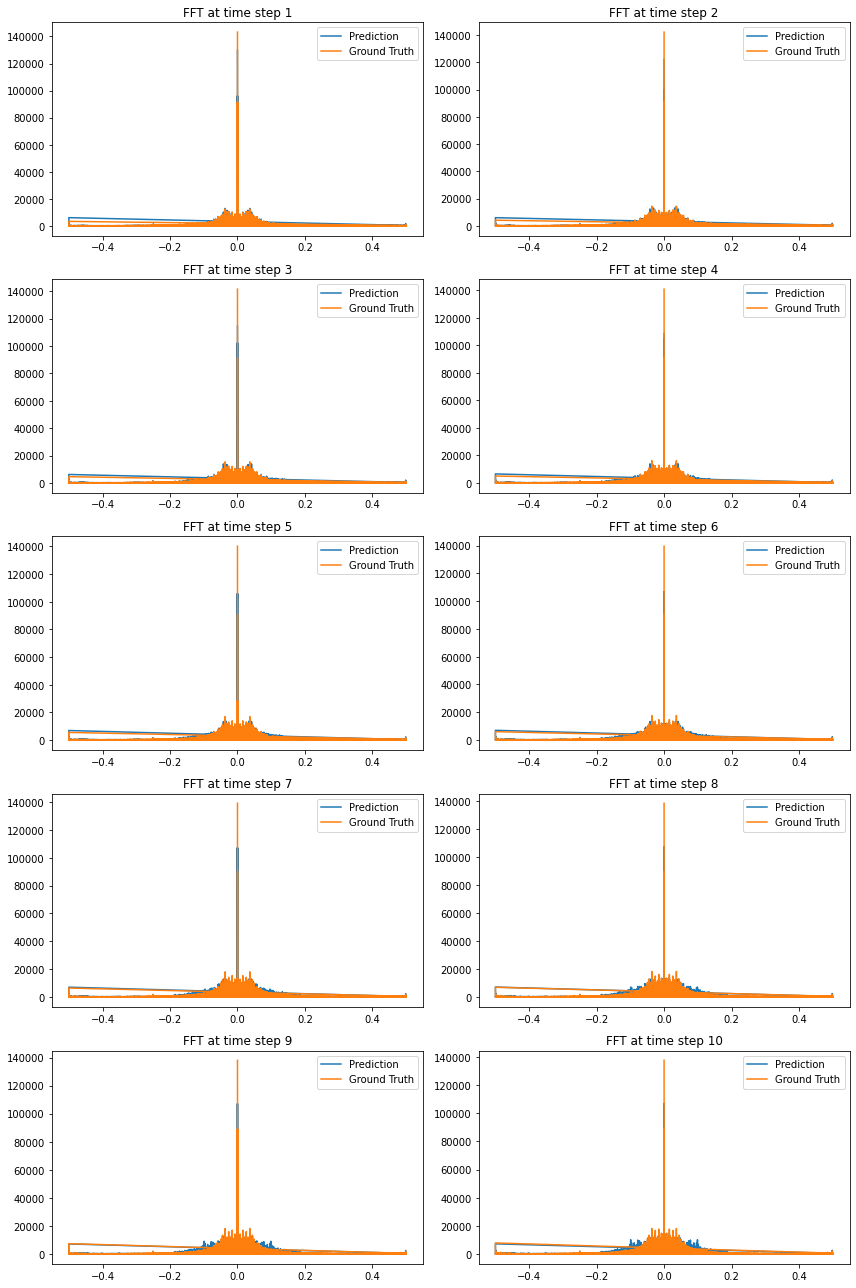

In [71]:
# Calculate the number of rows for the subplots
n = len(fft_data_predictions[:10])
cols = 2
rows = n // cols + (n % cols > 0)

# Create a new figure and a grid of subplots
fig, axs = plt.subplots(rows, cols, figsize=(12, 18))

# Flatten the axs array in case we have only one row
axs = axs.flatten()

# Iterate over all subplots and plot the FFT data
for i, ax in enumerate(axs):
    if i < n:
        fft_prediction = fft_data_predictions[i]
        fft_ground_truth = fft_data_ground_truth[i]

        # calculate FFT frequencies
        freq = np.fft.fftfreq(len(fft_prediction))
        ax.plot(freq, np.abs(fft_prediction), label='Prediction')
        ax.plot(freq, np.abs(fft_ground_truth), label='Ground Truth')
        ax.legend(loc='upper right')
        ax.set_title('FFT at time step ' + str(i + 1))
    else:
        # If there is no data, hide the extra subplots
        ax.axis('off')

# Adjust the spacing between subplots and display the figure
plt.tight_layout()
plt.show()

### calculate DFT/FFT

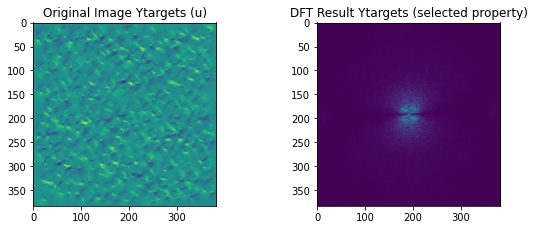

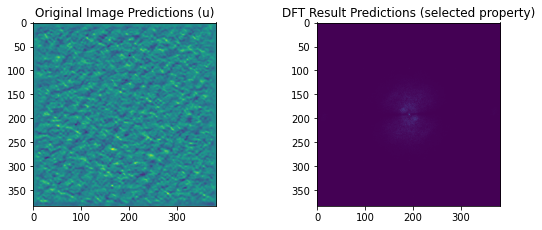

In [112]:
# Function to calculate DFT for each sample in an array
def calculate_dft_for_each_sample(data):
    # Calculate 2D Fourier Transform along the last two dimensions
    dft_result = np.fft.fft2(data, axes=(-2, -1))
    return dft_result

# Function to plot original images and DFT results for a specific property
def plot_images_and_dft(data, dft_result, property_index, title_prefix):
    plt.figure(figsize=(12, 6))

    # Plot original images
    plt.subplot(231)
    plt.imshow(data[sample_index, property_index], cmap='viridis')
    plt.title(f'Original Image {title_prefix} (u)')

    # Plot DFT results
    plt.subplot(232)
    plt.imshow(np.abs(np.fft.fftshift(dft_result[sample_index, property_index])), cmap='viridis')
    plt.title(f'DFT Result {title_prefix} (selected property)')

    plt.tight_layout()
    plt.show()

# Calculate DFT for each sample in both arrays
dft_result_Ytargets = calculate_dft_for_each_sample(numpy_array_Samples_Ytargets)
dft_result_Predictions = calculate_dft_for_each_sample(numpy_array_Samples_Predictions)

# Display the original images and their DFT results for the first sample
sample_index = 2

# Choose which property to plot (0 for u, 1 for v)
property_index_to_plot = 1

# Plot for Ytargets
plot_images_and_dft(numpy_array_Samples_Ytargets, dft_result_Ytargets, property_index_to_plot, 'Ytargets')

# Plot for Predictions
plot_images_and_dft(numpy_array_Samples_Predictions, dft_result_Predictions, property_index_to_plot, 'Predictions')
